In [1]:
import librosa as lbr
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

In [12]:
def L2(x: list):
    return np.sqrt(np.sum(np.square(x)))

def matching_pursuit(x: list, d: list, k: int=1000, eps: float=0.001) -> list:

    """
    x: sig 1D array
    d: dictionary 2D array
    k: max number of atoms to be extract
    eps: max error

    return -> coeff 1D array, atoms 2D array
    """

    coeff = []
    atoms = []
    residual = x.copy()
    dic = d.copy()
    
    l2_sig = L2(x)

    i = 0
    while L2(residual)/l2_sig > eps:

        dot = np.dot(dic, residual)
        max_ndx = np.argmax(np.abs(dot))

        coeff.append(dot[max_ndx])
        atoms.append(dic[max_ndx])

        residual = residual - coeff[-1] * atoms[-1]

        i += 1

        if i == k:
            break

    
    return np.array(coeff, dtype=float), np.array(atoms, dtype=float)





In [13]:
N = 1024
t1 = np.linspace(0, 2 * np.pi, N)
t2 = np.linspace(0, 4 * np.pi, N)
t3 = np.linspace(0, 7 * np.pi, N)
sig = np.sin(t1) + np.sin(t2) + np.sin(t3) # + (np.random.uniform(size=(N)) * 0.9)
D = np.random.uniform(low=-0.05, high=0.05, size=(N, N))
# plt.plot(sig)

In [14]:
coeff, atoms= matching_pursuit(x=sig, d=D, k=1000, eps=1e-9)

In [15]:
rebuild_signal = np.sum(coeff * atoms.T, axis=1)
rebuild_signal

array([-0.24385161, -0.38898267,  0.14975129, ..., -0.133151  ,
       -0.28125069, -0.1376216 ])

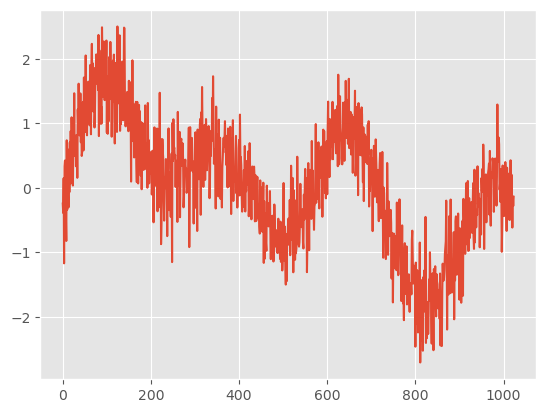

In [16]:
plt.plot(rebuild_signal)

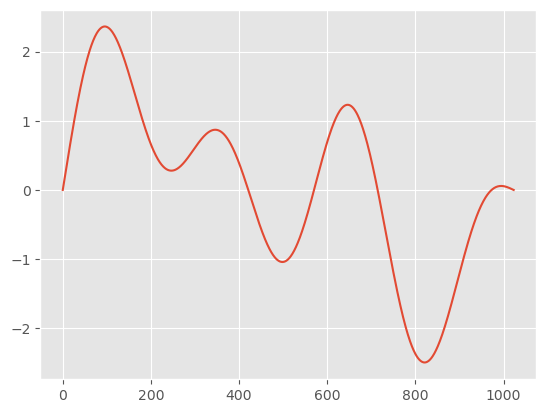

In [17]:
plt.plot(sig)

In [2]:
TARGET = "./audio_file/vox.wav"
SOURCE = "./audio_file/classical.wav"
SR = 44100
WLEN = 4096
HOPSIZE = 1024

In [3]:
target, _ = lbr.load(TARGET, sr=SR)
source, _ = lbr.load(SOURCE, sr=SR)

In [20]:
def signal_segmentation(x: list, wlen: int, hopsize: int):
    n = x.size
    segments = []
    hop = 0
    while n - hop > wlen:
        s = x[hop:hop+wlen]
        segments.append(s * np.hanning(wlen))
        hop += hopsize
    last_w = np.zeros(wlen)
    last_index = x.size - hop
    last_w[:last_index] = x[hop:]
    segments.append(last_w * np.hanning(wlen))
    
    segments = np.array(segments, dtype=float)
    return segments
    
def pre_process_signals(target: list, source: list, wlen: int, hopsize: int):

    target_frames = signal_segmentation(x=target, wlen=wlen, hopsize=hopsize)
    source_frames = signal_segmentation(x=source, wlen=wlen, hopsize=hopsize)

    w = np.hamming(wlen) # gauss win

    target_atoms, source_atoms = [], []

    for t in target_frames:
        fft_target = np.fft.rfft(t).real
        target_atoms.append(fft_target)

    for s in source_frames:
        fft_source = np.fft.rfft(s * w).real
        source_atoms.append(fft_source/np.linalg.norm(fft_source))
    
    return np.array(target_atoms), np.array(source_atoms)

def matching_pursuit_process(x: list, dictionary: list, k: int, eps: float=1e-6):

    match = []
    for frame in x:
        coeffs, atoms = matching_pursuit(x=frame, d=dictionary, k=k, eps=eps)
        atom = np.sum(coeffs * atoms.T, axis=1)
        match.append(atom)
    
    return np.array(match)

def rebuild_signal(frames: list, hopsize):
    ifft_frames = []
    
    for frame in frames:
        ifft_frames.append(np.fft.irfft(frame))
    
    ifft_frames = np.array(ifft_frames)

    n = (ifft_frames.shape[0] * hopsize) + ifft_frames.shape[1]
    y = np.zeros(n, dtype=float)

    hop, w = 0, ifft_frames.shape[1]
    for f in ifft_frames:
        y[hop:hop+w] += f * np.hanning(w)
        hop += hopsize
    
    return y


In [24]:
signal_frames, dictionary = pre_process_signals(
    target=target,
    source=source, 
    wlen=WLEN,
    hopsize=HOPSIZE)

In [25]:
matching = matching_pursuit_process(
    x=signal_frames,
    dictionary=dictionary,
    k=10,
    eps=1e-5
)

In [26]:
y = rebuild_signal(frames=matching, hopsize=HOPSIZE)

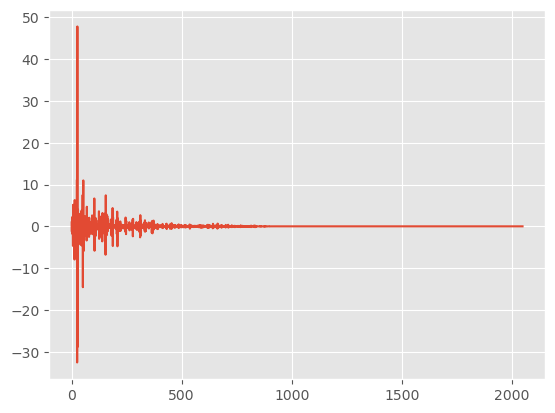

In [27]:
plt.plot(matching[10])

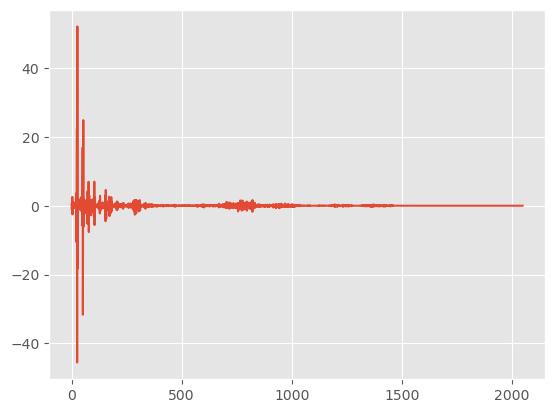

In [28]:
plt.plot(signal_frames[10])

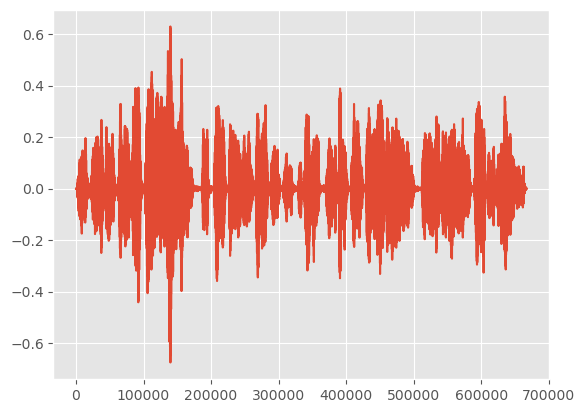

In [29]:
plt.plot(y)

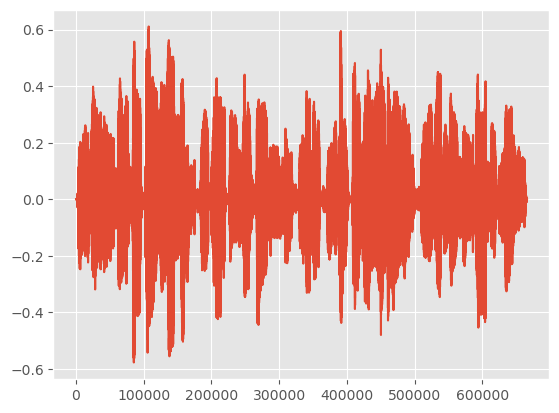

In [30]:
plt.plot(target)

In [7]:
from IPython.display import Audio

Audio(y, rate=44100)

In [137]:
import soundfile as sf

In [139]:
sf.write("./audio_file/generated_audio/vox_classical.wav", y, 44100, "PCM_24")